## Determine across batch correlations

**Gregory Way, 2021**

We've collected Cell Painting readouts for the same cell line clones and perturbations across many different batches. Determine across batch correlations here.

In [1]:
import pathlib
import pandas as pd
import plotnine as gg

from cytominer_eval import evaluate
from cytominer_eval.transform import metric_melt
from cytominer_eval.operations.util import assign_replicates
from pycytominer.cyto_utils import infer_cp_features

from scripts.processing_utils import load_data

In [2]:
data_dir = pathlib.Path("../0.generate-profiles/profiles")

cloneAE_data = {
    "2019_03_20_Batch2": ["207106_exposure320"],
    "2020_07_02_Batch8": ["218360", "218361"],
    "2021_02_08_Batch11": ["219814"]
}

profile_suffix = "normalized.csv.gz"

In [3]:
full_datasets_df = []
for batch in cloneAE_data:
    plates = cloneAE_data[batch]
    
    # Load and harmonize data for the given plates
    df = load_data(
        batch=batch,
        plates=plates,
        profile_dir=data_dir,
        suffix=profile_suffix,
        combine_dfs=True,
        harmonize_cols=True,
        add_cell_count=False
    )
    
    full_datasets_df.append(df)

In [4]:
full_datasets_df = pd.concat(full_datasets_df, axis="rows", sort=False).reset_index(drop=True)

features = infer_cp_features(full_datasets_df)
meta_features = infer_cp_features(full_datasets_df, metadata=True)

print(full_datasets_df.shape)
full_datasets_df.head()

(216, 3542)


,Metadata_Plate,Metadata_Well,Metadata_batch,Metadata_clone_number,Metadata_plate_map_name,Metadata_treatment,Cells_AreaShape_Area,Cells_AreaShape_Center_X,Cells_AreaShape_Center_Y,Cells_AreaShape_Center_Z,...,Nuclei_Texture_Variance_RNA_5_02,Nuclei_Texture_Variance_RNA_5_03,Metadata_cell_density,Metadata_plate_ID,Metadata_plate_filename,Metadata_treatment_time,Metadata_celltype_shorthand_from_plate_graph,Metadata_date,Metadata_time_to_adhere,Metadata_treatment_shorthand_from_plate_graph
0,207106_exposure320,B02,2019_03_20_Batch2,WT_parental,PlateMap_207106_exposure320,0.1% DMSO,-0.239970,0.774097,0.981307,0.0,...,-0.458918,-0.461595,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,207106_exposure320,B03,2019_03_20_Batch2,WT_parental,PlateMap_207106_exposure320,0.1% DMSO,-0.324702,-1.704724,0.793306,0.0,...,-0.404893,-0.403287,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,207106_exposure320,B04,2019_03_20_Batch2,WT_parental,PlateMap_207106_exposure320,0.1% DMSO,-0.283277,1.097421,0.998398,0.0,...,-0.414115,-0.415869,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,207106_exposure320,B05,2019_03_20_Batch2,CloneA,PlateMap_207106_exposure320,0.1% DMSO,-2.162447,0.789493,-0.471426,0.0,...,-0.825891,-0.824499,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,207106_exposure320,B06,2019_03_20_Batch2,CloneA,PlateMap_207106_exposure320,0.1% DMSO,-1.269935,-0.365237,-0.830337,0.0,...,-0.867076,-0.866256,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# Melt a pairwise similarity matrix
similarity_melted_df = metric_melt(
    df=full_datasets_df,
    features=features,
    metadata_features=meta_features,
    similarity_metric="pearson",
    eval_metric="grit",
)

# Determine which samples are replicates
replicate_groups = ["Metadata_batch", "Metadata_clone_number", "Metadata_treatment"]
similarity_melted_df = assign_replicates(
    similarity_melted_df=similarity_melted_df,
    replicate_groups=replicate_groups
)

In [6]:
same_treatment_across_batch_replicate = (
    similarity_melted_df.Metadata_clone_number_replicate &
    similarity_melted_df.Metadata_treatment_replicate &
    ~(similarity_melted_df.Metadata_batch_replicate)
)

different_treatment_within_batch = (
    similarity_melted_df.Metadata_batch_replicate &
    ~(similarity_melted_df.group_replicate) 
)

In [7]:
similarity_melted_df = similarity_melted_df.assign(comparison_category="across_batch_nonreplicate")
similarity_melted_df.loc[similarity_melted_df.group_replicate, "comparison_category"] = "same_batch_replicate"
similarity_melted_df.loc[same_treatment_across_batch_replicate, "comparison_category"] = "across_batch_replicate"
similarity_melted_df.loc[different_treatment_within_batch, "comparison_category"] = "same_batch_nonreplicate"

In [8]:
similarity_melted_df.comparison_category.value_counts()

across_batch_nonreplicate    26120
same_batch_nonreplicate      17652
same_batch_replicate          1428
across_batch_replicate        1240
Name: comparison_category, dtype: int64

In [9]:
similarity_melted_df.Metadata_clone_number_pair_a.value_counts()

WT_parental    13760
CloneA         12040
CloneE         12040
WT clone 04      860
BZ005            860
BZ003            860
WT clone 01      860
WT clone 03      860
BZ004            860
BZ002            860
WT clone 05      860
WT clone 02      860
BZ001            860
Name: Metadata_clone_number_pair_a, dtype: int64

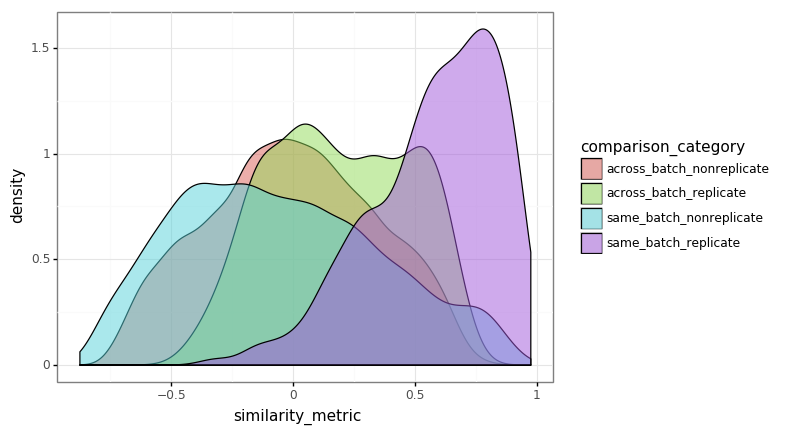

<ggplot: (-9223363263399776603)>

In [10]:
(
    gg.ggplot(similarity_melted_df, gg.aes(x="similarity_metric"))
    + gg.geom_density(gg.aes(fill="comparison_category"), alpha=0.5)
    + gg.theme_bw()
)

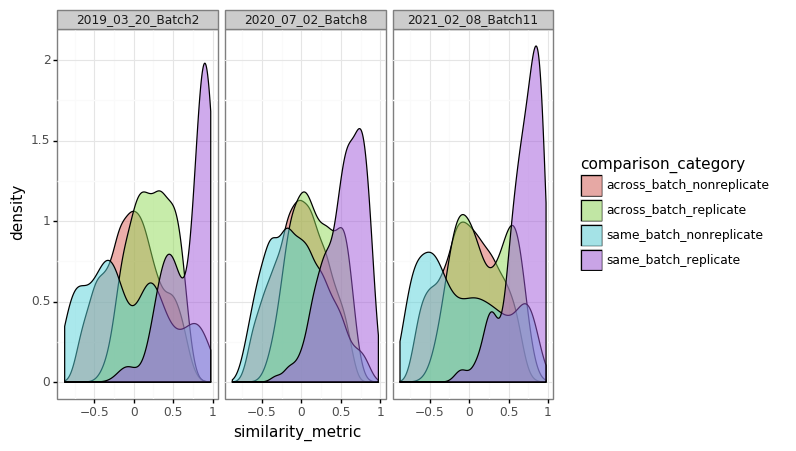

<ggplot: (-9223363263399823556)>

In [11]:
(
    gg.ggplot(similarity_melted_df, gg.aes(x="similarity_metric"))
    + gg.geom_density(gg.aes(fill="comparison_category"), alpha=0.5)
    + gg.theme_bw()
    + gg.facet_wrap("~Metadata_batch_pair_a")
)

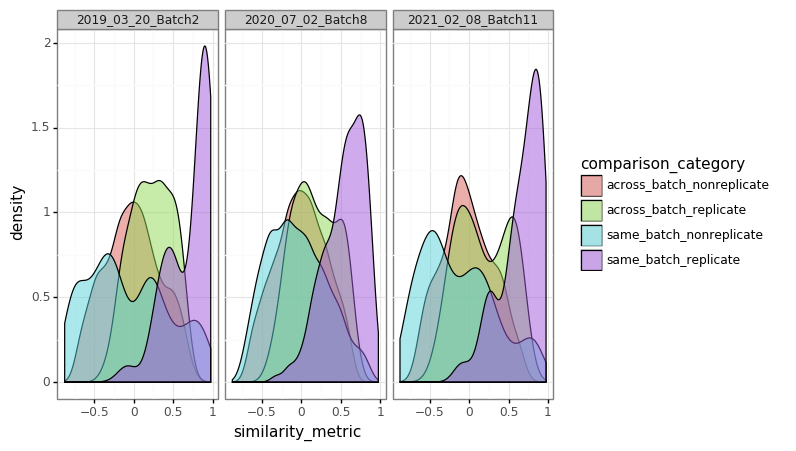

<ggplot: (8773503302450)>

In [12]:
(
    gg.ggplot(
        similarity_melted_df.query("Metadata_clone_number_pair_a in ['WT_parental', 'CloneA', 'CloneE']"),
        gg.aes(x="similarity_metric"))
    + gg.geom_density(gg.aes(fill="comparison_category"), alpha=0.5)
    + gg.theme_bw()
    + gg.facet_wrap("~Metadata_batch_pair_a")
)

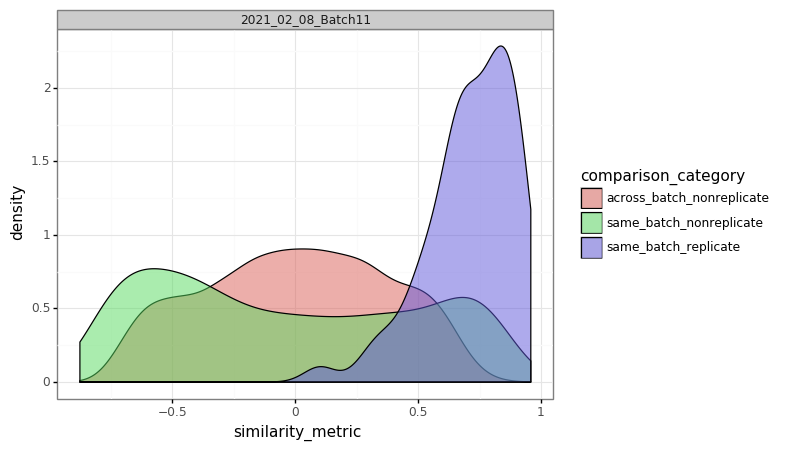

<ggplot: (-9223363263399815431)>

In [13]:
(
    gg.ggplot(
        similarity_melted_df.query("Metadata_clone_number_pair_a not in ['WT_parental', 'CloneA', 'CloneE']"),
        gg.aes(x="similarity_metric"))
    + gg.geom_density(gg.aes(fill="comparison_category"), alpha=0.5)
    + gg.theme_bw()
    + gg.facet_wrap("~Metadata_batch_pair_a")
)

In [14]:
# Load and process data
data_dir = pathlib.Path("data/merged")
file = pathlib.Path(data_dir, "all_merged_profiles.csv.gz")

data_df = pd.read_csv(file)

# Create columns for grit calculation
data_df = data_df.assign(
    Metadata_treatment_group_id=data_df.Metadata_clone_number + "_" + data_df.Metadata_treatment
)
data_df = data_df.assign(
    Metadata_treatment_profile_id=data_df.Metadata_treatment_group_id + "_" + data_df.Metadata_batch
)

features = infer_cp_features(data_df)
meta_features = infer_cp_features(data_df, metadata=True)

print(data_df.shape)
data_df.head()

(3957, 460)


,Metadata_Plate,Metadata_Well,Metadata_batch,Metadata_cell_count,Metadata_cell_density,Metadata_celltype_shorthand_from_plate_graph,Metadata_clone_number,Metadata_date,Metadata_plate_map_name,Metadata_time_to_adhere,...,Nuclei_Texture_Entropy_DNA_20_03,Nuclei_Texture_Entropy_ER_20_03,Nuclei_Texture_InfoMeas1_DNA_5_02,Nuclei_Texture_InfoMeas1_ER_5_00,Nuclei_Texture_InfoMeas1_Mito_5_00,Nuclei_Texture_InfoMeas1_RNA_5_00,Nuclei_Texture_SumAverage_DNA_20_03,Nuclei_Texture_SumVariance_AGP_20_03,Metadata_treatment_group_id,Metadata_treatment_profile_id
0,219905,B02,2021_03_03_Batch14,4269,2.5x10^3 cells/well,1.0,WT_parental,20210219.0,219905,48 hr,...,-1.525862,-0.689886,1.381230,1.683708,0.890482,1.819708,-0.654685,-1.201057,WT_parental_2.33 nM bortezomib,WT_parental_2.33 nM bortezomib_2021_03_03_Batch14
1,219905,B03,2021_03_03_Batch14,1688,2.5x10^3 cells/well,2.0,CloneA,20210219.0,219905,48 hr,...,-0.737619,-0.873918,0.133264,-0.753028,-0.729984,-0.761175,-1.688990,-0.894227,CloneA_2.33 nM bortezomib,CloneA_2.33 nM bortezomib_2021_03_03_Batch14
2,219905,B04,2021_03_03_Batch14,2238,2.5x10^3 cells/well,3.0,CloneE,20210219.0,219905,48 hr,...,-1.144326,-2.081855,0.613646,0.124588,0.677733,-0.322159,-1.776875,-1.199676,CloneE_2.33 nM bortezomib,CloneE_2.33 nM bortezomib_2021_03_03_Batch14
3,219905,B05,2021_03_03_Batch14,3358,2.5x10^3 cells/well,4.0,WT clone 01,20210219.0,219905,48 hr,...,-1.467039,-1.865624,1.895769,1.285182,0.735492,1.617357,-1.205825,-1.531649,WT clone 01_2.33 nM bortezomib,WT clone 01_2.33 nM bortezomib_2021_03_03_Batch14
4,219905,B06,2021_03_03_Batch14,291,2.5x10^3 cells/well,5.0,WT clone 02,20210219.0,219905,48 hr,...,1.874837,0.763804,-1.437746,-0.150566,-0.905429,-0.617372,1.571506,0.849895,WT clone 02_2.33 nM bortezomib,WT clone 02_2.33 nM bortezomib_2021_03_03_Batch14


In [15]:
# Select only batches that have "WT_parental_0.1% DMSO" as a treatment group
grit_control_pert = "WT_parental_0.1% DMSO"

select_batches = sorted(
    data_df.query("Metadata_treatment_group_id == @grit_control_pert").Metadata_batch.unique().tolist()
)

select_batches

['2019_02_15_Batch1_20X',
 '2019_03_20_Batch2',
 '2019_11_11_Batch4',
 '2019_11_19_Batch5',
 '2019_11_20_Batch6',
 '2019_11_22_Batch7',
 '2020_07_02_Batch8',
 '2020_08_24_Batch9',
 '2020_09_08_Batch10',
 '2021_02_08_Batch11',
 '2021_03_03_Batch12',
 '2021_03_03_Batch13',
 '2021_03_03_Batch14',
 '2021_03_03_Batch15',
 '2021_03_05_Batch16',
 '2021_03_05_Batch17',
 '2021_03_12_Batch18',
 '2021_03_12_Batch19',
 '2021_06_25_Batch20',
 '2021_06_25_Batch21',
 '2021_07_21_Batch22',
 '2021_07_21_Batch23',
 '2021_08_02_Batch24',
 '2021_08_02_Batch25',
 '2021_08_03_Batch26',
 '2021_08_03_Batch27']

In [16]:
all_grit_control_perts = data_df.query("Metadata_batch in @select_batches").query("Metadata_treatment_group_id == @grit_control_pert").Metadata_treatment_profile_id.unique()
all_grit_control_perts

array(['WT_parental_0.1% DMSO_2021_03_03_Batch14',
       'WT_parental_0.1% DMSO_2021_03_03_Batch13',
       'WT_parental_0.1% DMSO_2021_03_03_Batch12',
       'WT_parental_0.1% DMSO_2021_03_03_Batch15',
       'WT_parental_0.1% DMSO_2020_08_24_Batch9',
       'WT_parental_0.1% DMSO_2021_03_05_Batch17',
       'WT_parental_0.1% DMSO_2021_03_05_Batch16',
       'WT_parental_0.1% DMSO_2021_02_08_Batch11',
       'WT_parental_0.1% DMSO_2021_08_03_Batch26',
       'WT_parental_0.1% DMSO_2021_07_21_Batch22',
       'WT_parental_0.1% DMSO_2021_07_21_Batch23',
       'WT_parental_0.1% DMSO_2021_08_03_Batch27',
       'WT_parental_0.1% DMSO_2019_03_20_Batch2',
       'WT_parental_0.1% DMSO_2020_09_08_Batch10',
       'WT_parental_0.1% DMSO_2020_07_02_Batch8',
       'WT_parental_0.1% DMSO_2019_11_11_Batch4',
       'WT_parental_0.1% DMSO_2021_03_12_Batch18',
       'WT_parental_0.1% DMSO_2021_06_25_Batch21',
       'WT_parental_0.1% DMSO_2021_03_12_Batch19',
       'WT_parental_0.1% DMSO_2021_

In [17]:
meta_features

['Metadata_Plate',
 'Metadata_Well',
 'Metadata_batch',
 'Metadata_cell_count',
 'Metadata_cell_density',
 'Metadata_celltype_shorthand_from_plate_graph',
 'Metadata_clone_number',
 'Metadata_date',
 'Metadata_plate_map_name',
 'Metadata_time_to_adhere',
 'Metadata_treatment',
 'Metadata_treatment_shorthand_from_plate_graph',
 'Metadata_treatment_time',
 'Metadata_clone_type',
 'Metadata_treatment_group_id',
 'Metadata_treatment_profile_id']

In [18]:
data_df.Metadata_treatment_profile_id.value_counts()

WT_parental_0.1% DMSO_2021_03_12_Batch19    36
WT_parental_0.1% DMSO_2021_03_03_Batch14    36
WT_parental_0.1% DMSO_2021_07_21_Batch23    36
WT_parental_0.1% DMSO_2021_03_05_Batch17    36
WT_parental_0.1% DMSO_2021_03_03_Batch15    36
                                            ..
CloneE_0.1% DMSO_2019_02_15_Batch1_20X       3
WT008_21 nM bortezomib_2019_11_19_Batch5     3
BZ003_Untreated_2019_06_25_Batch3            3
BZ008_Untreated_2019_06_25_Batch3            3
CloneA_0.1% DMSO_2019_03_20_Batch2           3
Name: Metadata_treatment_profile_id, Length: 706, dtype: int64

In [19]:
# Get replicate correlation
percent_strong, corr_df = evaluate(
    profiles=data_df,
    features=features,
    meta_features=meta_features,
    replicate_groups=["Metadata_clone_number", "Metadata_treatment"],
    operation="replicate_reproducibility",
    replicate_reproducibility_return_median_cor=True
)

In [20]:
percent_strong

0.22549047524132237

In [21]:
corr_df.head()

,Metadata_clone_number,Metadata_treatment,similarity_metric
0,BZ001,0.1% DMSO,0.209684
1,BZ001,0.78 nM bortezomib,0.197908
2,BZ001,2.33 nM bortezomib,0.300190
3,BZ001,21 nM bortezomib,0.245967
4,BZ001,7 nM bortezomib,0.242292


In [22]:
# Get technical grit for batch
replicate_groups = {
    "profile_col": "Metadata_treatment_profile_id",
    "replicate_group_col": "Metadata_treatment_group_id"
}

grit_df = evaluate(
    profiles=data_df.query("Metadata_batch in @select_batches"),
    features=features,
    meta_features=meta_features,
    replicate_groups=replicate_groups,
    operation="grit",
    grit_control_perts=all_grit_control_perts
)

In [23]:
grit_df.sort_values(by="grit", ascending=False)

,perturbation,group,grit
136,BZ007_0.78 nM bortezomib_2021_08_02_Batch25,BZ007_0.78 nM bortezomib,4.923696
142,BZ007_7 nM bortezomib_2021_08_02_Batch25,BZ007_7 nM bortezomib,4.900630
134,BZ007_0.78 nM bortezomib_2021_06_25_Batch21,BZ007_0.78 nM bortezomib,4.830860
139,BZ007_2.33 nM bortezomib_2021_08_02_Batch25,BZ007_2.33 nM bortezomib,4.624418
138,BZ007_2.33 nM bortezomib_2021_07_21_Batch23,BZ007_2.33 nM bortezomib,4.608819
135,BZ007_0.78 nM bortezomib_2021_07_21_Batch23,BZ007_0.78 nM bortezomib,4.550966
140,BZ007_7 nM bortezomib_2021_06_25_Batch21,BZ007_7 nM bortezomib,4.316570
174,BZ009_0.78 nM bortezomib_2021_08_02_Batch25,BZ009_0.78 nM bortezomib,4.251481
133,BZ007_0.1% DMSO_2021_08_02_Batch25,BZ007_0.1% DMSO,4.208587
172,BZ009_0.78 nM bortezomib_2021_06_25_Batch21,BZ009_0.78 nM bortezomib,4.125986
